In [326]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [327]:
cd /content/drive/My Drive/Data Mining/H1N1 prediction project

/content/drive/My Drive/Data Mining/H1N1 prediction project


In [0]:
from pathlib import Path

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
import xgboost as xgb

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve, roc_auc_score

pd.set_option("display.max_columns", 100)

In [0]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier 

# LOADING THE DATA

In [0]:
features1_df = pd.read_csv(
    "training_set_features.csv", 
    index_col="respondent_id"
)
labels_df = pd.read_csv(
    "training_set_labels.csv", 
    index_col="respondent_id"
)
test_features_df = pd.read_csv("test_set_features.csv", 
                               index_col="respondent_id")

In [331]:
print("features1_df.shape", features_df.shape)
features_df.head()


features1_df.shape (26707, 35)


,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,-1,-1
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,1,1,0,1,0,0,1,1,1,1,0.0,0.0,0,0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,2,2,0,1,1,0,0,1,2,1,2.0,0.0,1,1
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,3,1,0,0,0,0,1,0,3,2,0.0,0.0,-1,-1
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,4,3,0,0,1,1,0,1,2,1,1.0,0.0,2,2


In [332]:
print("features_df.shape", labels_df.shape)
labels_df.head()

features_df.shape (26707, 2)


,h1n1_vaccine,seasonal_vaccine
respondent_id,,
0,0,0
1,0,1
2,0,0
3,0,1
4,0,0


# EXPLORING THE DATA

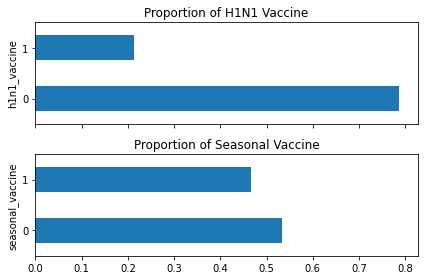

In [333]:
fig, ax = plt.subplots(2, 1, sharex=True)

n_obs = labels_df.shape[0]

(labels_df['h1n1_vaccine']
    .value_counts()
    .div(n_obs)
    .plot.barh(title="Proportion of H1N1 Vaccine", ax=ax[0])
)
ax[0].set_ylabel("h1n1_vaccine")

(labels_df['seasonal_vaccine']
    .value_counts()
    .div(n_obs)
    .plot.barh(title="Proportion of Seasonal Vaccine", ax=ax[1])
)
ax[1].set_ylabel("seasonal_vaccine")

fig.tight_layout()

In [334]:
print('unique age groups:',features1_df['age_group'].nunique())
print('unique education:',features1_df['education'].nunique())
print('unique race:',features1_df['race'].nunique())
print('unique sex:',features1_df['sex'].nunique())
print('unique income_poverty:',features1_df['income_poverty'].nunique())
print('unique marital_status:',features1_df['marital_status'].nunique())
print('unique rent_or_own:',features1_df['rent_or_own'].nunique())
print('unique employment_status:',features1_df['employment_status'].nunique())
print('unique hhs_geo_region:',features1_df['hhs_geo_region'].nunique())
print('unique census_msa:',features1_df['census_msa'].nunique())
print('unique employment_industry:',features1_df['employment_industry'].nunique())
print('unique employment_occupation:',features1_df['employment_occupation'].nunique())


unique age groups: 5
unique education: 4
unique race: 4
unique sex: 2
unique income_poverty: 3
unique marital_status: 2
unique rent_or_own: 2
unique employment_status: 3
unique hhs_geo_region: 10
unique census_msa: 3
unique employment_industry: 21
unique employment_occupation: 23


In [335]:
features1_df['employment_industry'].unique()

array([nan, 'pxcmvdjn', 'rucpziij', 'wxleyezf', 'saaquncn', 'xicduogh',
       'ldnlellj', 'wlfvacwt', 'nduyfdeo', 'fcxhlnwr', 'vjjrobsf',
       'arjwrbjb', 'atmlpfrs', 'msuufmds', 'xqicxuve', 'phxvnwax',
       'dotnnunm', 'mfikgejo', 'cfqqtusy', 'mcubkhph', 'haxffmxo',
       'qnlwzans'], dtype=object)

In [0]:
frames = [features1_df, test_features_df]
features_df = pd.concat(frames)

In [337]:
features_df.shape

(53415, 35)

In [338]:
features_df['age_group'] = pd.factorize(features_df.age_group)[0]
features_df['age_group'] = features_df['age_group'].astype("category")
print(features_df['age_group'])

respondent_id
0        0
1        1
2        2
3        3
4        4
        ..
53410    1
53411    2
53412    2
53413    0
53414    4
Name: age_group, Length: 53415, dtype: category
Categories (5, int64): [0, 1, 2, 3, 4]


In [339]:
features_df['education'] = pd.factorize(features_df.education)[0]
features_df['education'] = features_df['education'].astype("category")
print(features_df['education'])

respondent_id
0        0
1        1
2        2
3        1
4        3
        ..
53410   -1
53411    1
53412    3
53413    3
53414    2
Name: education, Length: 53415, dtype: category
Categories (5, int64): [-1, 0, 1, 2, 3]


In [340]:
features_df['race'] = pd.factorize(features_df.race)[0]
features_df['race'] = features_df['race'].astype("category")
print(features_df['race'])

respondent_id
0        0
1        0
2        0
3        0
4        0
        ..
53410    0
53411    0
53412    0
53413    0
53414    0
Name: race, Length: 53415, dtype: category
Categories (4, int64): [0, 1, 2, 3]


In [341]:
features_df['sex'] = pd.factorize(features_df.sex)[0]
features_df['sex'] = features_df['sex'].astype("category")
print(features_df['sex'])

respondent_id
0        0
1        1
2        1
3        0
4        0
        ..
53410    0
53411    1
53412    0
53413    0
53414    0
Name: sex, Length: 53415, dtype: category
Categories (2, int64): [0, 1]


In [342]:
features_df['income_poverty'] = pd.factorize(features_df.income_poverty)[0]
features_df['income_poverty'] = features_df['income_poverty'].astype("category")
print(features_df['income_poverty'])

respondent_id
0        0
1        0
2        1
3        0
4        1
        ..
53410   -1
53411    0
53412    0
53413    1
53414   -1
Name: income_poverty, Length: 53415, dtype: category
Categories (4, int64): [-1, 0, 1, 2]


In [343]:
features_df['marital_status'] = pd.factorize(features_df.marital_status)[0]
features_df['marital_status'] = features_df['marital_status'].astype("category")
print(features_df['marital_status'])

respondent_id
0        0
1        0
2        0
3        0
4        1
        ..
53410   -1
53411    1
53412    0
53413    1
53414    0
Name: marital_status, Length: 53415, dtype: category
Categories (3, int64): [-1, 0, 1]


In [344]:
features_df['rent_or_own'] = pd.factorize(features_df.rent_or_own)[0]
features_df['rent_or_own'] = features_df['rent_or_own'].astype("category")
print(features_df['rent_or_own'])

respondent_id
0        0
1        1
2        0
3        1
4        0
        ..
53410   -1
53411    1
53412    1
53413    0
53414    1
Name: rent_or_own, Length: 53415, dtype: category
Categories (3, int64): [-1, 0, 1]


In [345]:
features_df['employment_status'] = pd.factorize(features_df.employment_status)[0]
features_df['employment_status'] = features_df['employment_status'].astype("category")
print(features_df['employment_status'])

respondent_id
0        0
1        1
2        1
3        0
4        1
        ..
53410   -1
53411    1
53412    0
53413    0
53414    1
Name: employment_status, Length: 53415, dtype: category
Categories (4, int64): [-1, 0, 1, 2]


In [346]:
features_df['hhs_geo_region'] = pd.factorize(features_df.hhs_geo_region)[0]
features_df['hhs_geo_region'] = features_df['hhs_geo_region'].astype("category")
print(features_df['hhs_geo_region'])

respondent_id
0        0
1        1
2        2
3        3
4        2
        ..
53410    8
53411    2
53412    2
53413    1
53414    3
Name: hhs_geo_region, Length: 53415, dtype: category
Categories (10, int64): [0, 1, 2, 3, ..., 6, 7, 8, 9]


In [347]:
features_df['census_msa'] = pd.factorize(features_df.census_msa)[0]
features_df['census_msa'] = features_df['census_msa'].astype("category")
print(features_df['census_msa'])

respondent_id
0        0
1        1
2        1
3        2
4        1
        ..
53410    2
53411    0
53412    1
53413    1
53414    2
Name: census_msa, Length: 53415, dtype: category
Categories (3, int64): [0, 1, 2]


In [348]:
features_df['employment_industry'] = pd.factorize(features_df.employment_industry)[0]
features_df['employment_industry'] = features_df['employment_industry'].astype("category")
print(features_df['employment_industry'])

respondent_id
0       -1
1        0
2        1
3       -1
4        2
        ..
53410   -1
53411    8
53412   -1
53413   -1
53414   -1
Name: employment_industry, Length: 53415, dtype: category
Categories (22, int64): [-1, 0, 1, 2, ..., 17, 18, 19, 20]


In [349]:
features_df['employment_occupation'] = pd.factorize(features_df.employment_occupation)[0]
features_df['employment_occupation'] = features_df['employment_occupation'].astype("category")
print(features_df['employment_occupation'])

respondent_id
0       -1
1        0
2        1
3       -1
4        2
        ..
53410   -1
53411    3
53412   -1
53413   -1
53414    1
Name: employment_occupation, Length: 53415, dtype: category
Categories (24, int64): [-1, 0, 1, 2, ..., 19, 20, 21, 22]


In [0]:
features1_df, test_features_df = features_df[0:26707], features_df[26707:]

In [0]:
features_df = features1_df

In [352]:
pd.crosstab(
    labels_df["h1n1_vaccine"], 
    labels_df["seasonal_vaccine"], 
    margins=True,
    normalize=False
)

seasonal_vaccine,0,1,All
h1n1_vaccine,,,
0,13295,7738,21033
1,977,4697,5674
All,14272,12435,26707


In [353]:
# Phi Coefficient is the same as Pearson for two binary variables
(labels_df["h1n1_vaccine"]
     .corr(labels_df["seasonal_vaccine"], method="pearson")
)

0.37714265306144495

# Features

In [354]:
joined_df = features_df.join(labels_df)
print(joined_df.shape)
joined_df.head()

(26707, 37)


,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,-1,-1,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,1,1,0,1,0,0,1,1,1,1,0.0,0.0,0,0,0,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,2,2,0,1,1,0,0,1,2,1,2.0,0.0,1,1,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,3,1,0,0,0,0,1,0,3,2,0.0,0.0,-1,-1,0,1
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,4,3,0,0,1,1,0,1,2,1,1.0,0.0,2,2,0,0


In [355]:
counts = (joined_df[['h1n1_concern', 'h1n1_vaccine']]
              .groupby(['h1n1_concern', 'h1n1_vaccine'])
              .size()
              .unstack('h1n1_vaccine')
         )
counts

h1n1_vaccine,0,1
h1n1_concern,,
0.0,2849,447
1.0,6756,1397
2.0,8102,2473
3.0,3250,1341


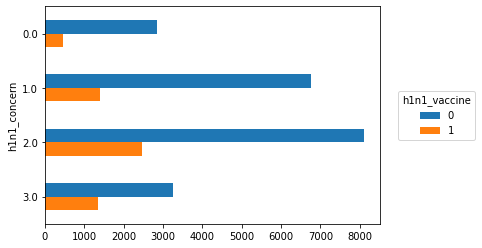

In [356]:
ax = counts.plot.barh()
ax.invert_yaxis()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.3, 0.5), 
    title='h1n1_vaccine'
)

In [357]:
h1n1_concern_counts = counts.sum(axis='columns')
h1n1_concern_counts

h1n1_concern
0.0     3296
1.0     8153
2.0    10575
3.0     4591
dtype: int64

In [358]:
props = counts.div(h1n1_concern_counts, axis='index')
props

h1n1_vaccine,0,1
h1n1_concern,,
0.0,0.864381,0.135619
1.0,0.828652,0.171348
2.0,0.766147,0.233853
3.0,0.707907,0.292093


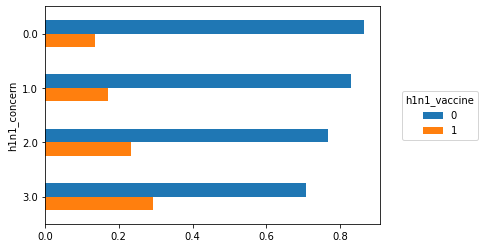

In [359]:
ax = props.plot.barh()
ax.invert_yaxis()
ax.legend(
    loc='center left', 
    bbox_to_anchor=(1.05, 0.5),
    title='h1n1_vaccine'
)

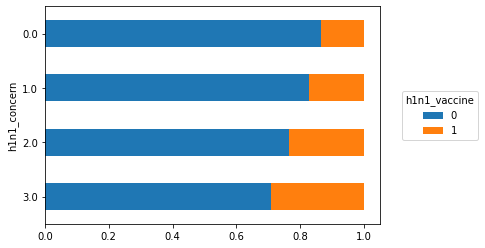

In [360]:
ax = props.plot.barh(stacked=True)
ax.invert_yaxis()
ax.legend(
    loc='center left', 
    bbox_to_anchor=(1.05, 0.5),
    title='h1n1_vaccine'
)

# BUILDING SOME MODELS

In [361]:
features_df.dtypes != "object"

h1n1_concern                   True
h1n1_knowledge                 True
behavioral_antiviral_meds      True
behavioral_avoidance           True
behavioral_face_mask           True
behavioral_wash_hands          True
behavioral_large_gatherings    True
behavioral_outside_home        True
behavioral_touch_face          True
doctor_recc_h1n1               True
doctor_recc_seasonal           True
chronic_med_condition          True
child_under_6_months           True
health_worker                  True
health_insurance               True
opinion_h1n1_vacc_effective    True
opinion_h1n1_risk              True
opinion_h1n1_sick_from_vacc    True
opinion_seas_vacc_effective    True
opinion_seas_risk              True
opinion_seas_sick_from_vacc    True
age_group                      True
education                      True
race                           True
sex                            True
income_poverty                 True
marital_status                 True
rent_or_own                 

In [362]:
numeric_cols = features_df.columns[features_df.dtypes != "object"].values
print(numeric_cols)

['h1n1_concern' 'h1n1_knowledge' 'behavioral_antiviral_meds'
 'behavioral_avoidance' 'behavioral_face_mask' 'behavioral_wash_hands'
 'behavioral_large_gatherings' 'behavioral_outside_home'
 'behavioral_touch_face' 'doctor_recc_h1n1' 'doctor_recc_seasonal'
 'chronic_med_condition' 'child_under_6_months' 'health_worker'
 'health_insurance' 'opinion_h1n1_vacc_effective' 'opinion_h1n1_risk'
 'opinion_h1n1_sick_from_vacc' 'opinion_seas_vacc_effective'
 'opinion_seas_risk' 'opinion_seas_sick_from_vacc' 'age_group' 'education'
 'race' 'sex' 'income_poverty' 'marital_status' 'rent_or_own'
 'employment_status' 'hhs_geo_region' 'census_msa' 'household_adults'
 'household_children' 'employment_industry' 'employment_occupation']


In [0]:
# chain preprocessing into a Pipeline object
# each step is a tuple of (name you chose, sklearn transformer)
numeric_preprocessing_steps = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('simple_imputer', SimpleImputer(strategy='median'))
])

# create the preprocessor stage of final pipeline
# each entry in the transformer list is a tuple of
# (name you choose, sklearn transformer, list of columns)
preprocessor = ColumnTransformer(
    transformers = [
        ("numeric", numeric_preprocessing_steps, numeric_cols)
    ],
    remainder = "drop"
)

In [0]:
estimators = MultiOutputClassifier(
    # estimator=LogisticRegression(penalty="l2", C=1)
    # estimator=RandomForestClassifier(random_state=1)
    #estimator=xgb.XGBClassifier(objective="binary:logistic", random_state=42)
    estimator = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=200))

In [0]:
full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("estimators", estimators),
])

## Training and Evaluation

In [0]:
X_train, X_eval, y_train, y_eval = train_test_split(
    features_df,
    labels_df,
    test_size=0.01,
    shuffle=True,
    stratify=labels_df,
    # random_state=RANDOM_SEED
)

In [367]:

# Train model
full_pipeline.fit(X_train, y_train)

# Predict on evaluation set
# This competition wants probabilities, not labels
preds = full_pipeline.predict_proba(X_eval)
preds

[array([[0.50241062, 0.49758938],
        [0.50583248, 0.49416752],
        [0.50430074, 0.49569926],
        [0.50301441, 0.49698559],
        [0.50229025, 0.49770975],
        [0.50394136, 0.49605864],
        [0.50299165, 0.49700835],
        [0.49985873, 0.50014127],
        [0.50238154, 0.49761846],
        [0.50440815, 0.49559185],
        [0.50580353, 0.49419647],
        [0.5043967 , 0.4956033 ],
        [0.49847261, 0.50152739],
        [0.50176044, 0.49823956],
        [0.50187696, 0.49812304],
        [0.50213748, 0.49786252],
        [0.504392  , 0.495608  ],
        [0.50273688, 0.49726312],
        [0.50311537, 0.49688463],
        [0.50439971, 0.49560029],
        [0.50304005, 0.49695995],
        [0.5035769 , 0.4964231 ],
        [0.50290698, 0.49709302],
        [0.50124536, 0.49875464],
        [0.50433004, 0.49566996],
        [0.50385401, 0.49614599],
        [0.5028594 , 0.4971406 ],
        [0.50275893, 0.49724107],
        [0.50363435, 0.49636565],
        [0.504

In [368]:

print("test_probas[0].shape", preds[0].shape)
print("test_probas[1].shape", preds[1].shape)

test_probas[0].shape (268, 2)
test_probas[1].shape (268, 2)


In [369]:
y_preds = pd.DataFrame(
    {
        "h1n1_vaccine": preds[0][:, 1],
        "seasonal_vaccine": preds[1][:, 1],
    },
    index = y_eval.index
)
print("y_preds.shape:", y_preds.shape)
y_preds.head()

y_preds.shape: (268, 2)


,h1n1_vaccine,seasonal_vaccine
respondent_id,,
21040,0.497589,0.501362
24986,0.494168,0.493652
8705,0.495699,0.498469
13208,0.496986,0.497759
21667,0.497710,0.503827


In [370]:
y_preds = pd.DataFrame(
    {
        "h1n1_vaccine": preds[0][:, 1],
        "seasonal_vaccine": preds[1][:, 1],
    },
    index = y_eval.index
)
print("y_preds.shape:", y_preds.shape)
y_preds.head()

y_preds.shape: (268, 2)


,h1n1_vaccine,seasonal_vaccine
respondent_id,,
21040,0.497589,0.501362
24986,0.494168,0.493652
8705,0.495699,0.498469
13208,0.496986,0.497759
21667,0.497710,0.503827


In [0]:
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
    )

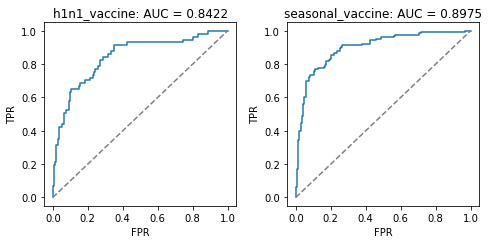

In [372]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))

plot_roc(
    y_eval['h1n1_vaccine'], 
    y_preds['h1n1_vaccine'], 
    'h1n1_vaccine',
    ax=ax[0]
)
plot_roc(
    y_eval['seasonal_vaccine'], 
    y_preds['seasonal_vaccine'], 
    'seasonal_vaccine',
    ax=ax[1]
)
fig.tight_layout()

In [373]:
roc_auc_score(y_eval, y_preds)

0.8698214774333508

In [374]:
full_pipeline.fit(features_df, labels_df)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numeric',
                                                  Pipeline(memory=None,
                                                           steps=[('standard_scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True)),
                                                                  ('simple_imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                 

# GENERATING THE PREDICTIONS FOR THE TEST SET

In [0]:
#test_features_df = pd.read_csv("test_set_features.csv", index_col="respondent_id")

In [376]:
test_probas = full_pipeline.predict_proba(test_features_df)
test_probas

[array([[0.50307651, 0.49692349],
        [0.50415106, 0.49584894],
        [0.50035395, 0.49964605],
        ...,
        [0.50268543, 0.49731457],
        [0.50346589, 0.49653411],
        [0.50023321, 0.49976679]]), array([[0.50090281, 0.49909719],
        [0.5039327 , 0.4960673 ],
        [0.4990103 , 0.5009897 ],
        ...,
        [0.50151793, 0.49848207],
        [0.50091921, 0.49908079],
        [0.50015835, 0.49984165]])]

In [0]:
submission_df = pd.read_csv("submission_format.csv", 
                            index_col="respondent_id")

In [378]:
# Make sure we have the rows in the same order
np.testing.assert_array_equal(test_features_df.index.values, 
                              submission_df.index.values)

# Save predictions to submission data frame
submission_df["h1n1_vaccine"] = test_probas[0][:, 1]
submission_df["seasonal_vaccine"] = test_probas[1][:, 1]

submission_df.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.496923,0.499097
26708,0.495849,0.496067
26709,0.499646,0.500990
26710,0.499414,0.502059
26711,0.498546,0.499345


In [0]:
submission_df.to_csv('Piyumal_submission_adaBoost_1.csv', index=True)